In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

# Open SOS Measurement Dataset

In [ ]:
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)

In [107]:
pivot_df = tidy_df[tidy_df.variable.isin([
    'u_h2o__3m_ue', 'v_h2o__3m_ue',
    'u_h2o__10m_ue','v_h2o__10m_ue',
    
    'u_h2o__3m_uw', 'v_h2o__3m_uw',
    'u_h2o__10m_uw','v_h2o__10m_uw',

    'u_h2o__3m_d', 'v_h2o__3m_d',
    'u_h2o__10m_d','v_h2o__10m_d',

    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
    'w_h2o__3m_c',
    'w_h2o__10m_c',
])][['time', 'variable', 'value']].pivot(index='time', columns='variable', values='value')


In [108]:
n1 = np.array([ np.cos(np.deg2rad(-188)),   np.sin(np.deg2rad(-188))])
n2 = np.array([ np.cos(np.deg2rad(-69)),   np.sin(np.deg2rad(-69))])
n3 = np.array([ np.cos(np.deg2rad(-312)),   np.sin(np.deg2rad(-312))])

In [134]:
face1_avg_flux = 0.25*(
    pivot_df[['u_h2o__3m_ue', 'v_h2o__3m_ue']].values +
    pivot_df[['u_h2o__10m_ue', 'v_h2o__10m_ue']].values +
    pivot_df[['u_h2o__3m_d', 'v_h2o__3m_d']].values +
    pivot_df[['u_h2o__10m_d', 'v_h2o__10m_d']].values
)
face2_avg_flux = 0.25*(
    pivot_df[['u_h2o__3m_uw', 'v_h2o__3m_uw']].values +
    pivot_df[['u_h2o__10m_uw', 'v_h2o__10m_uw']].values +
    pivot_df[['u_h2o__3m_d', 'v_h2o__3m_d']].values +
    pivot_df[['u_h2o__10m_d', 'v_h2o__10m_d']].values
)
face3_avg_flux = 0.25*(
    pivot_df[['u_h2o__3m_uw', 'v_h2o__3m_uw']].values +
    pivot_df[['u_h2o__10m_uw', 'v_h2o__10m_uw']].values +
    pivot_df[['u_h2o__3m_ue', 'v_h2o__3m_ue']].values +
    pivot_df[['u_h2o__10m_ue', 'v_h2o__10m_ue']].values
)
average_upward_3m_flux = 0.25*(
    pivot_df['w_h2o__3m_ue'] +
    pivot_df['w_h2o__3m_uw'] +
    pivot_df['w_h2o__3m_d'] +
    pivot_df['w_h2o__3m_c']
)

average_upward_10m_flux = 0.25*(
    pivot_df['w_h2o__10m_ue'] +
    pivot_df['w_h2o__10m_uw'] +
    pivot_df['w_h2o__10m_d'] +
    pivot_df['w_h2o__10m_c']
)

face1_projected_flux = np.dot(face1_avg_flux, n1)
face2_projected_flux = np.dot(face2_avg_flux, n2)
face3_projected_flux = np.dot(face3_avg_flux, n3)

In [135]:
# Define face areas
A1 = A2 = A3 = 37*10
A4 = A5 = 580.2

In [136]:
A1, A2, A3

(370, 370, 370)

In [145]:
pivot_df['face1_projected_flux'] = face1_projected_flux
pivot_df['face2_projected_flux'] = face2_projected_flux
pivot_df['face3_projected_flux'] = face3_projected_flux
pivot_df['sum_face_projected_flux'] = face1_projected_flux + face2_projected_flux + face3_projected_flux
pivot_df['vertical_divergence'] = average_upward_10m_flux - average_upward_3m_flux

pivot_df['total_divergence'] = (
    pivot_df['face1_projected_flux']*A1 + 
    pivot_df['face2_projected_flux']*A2 + 
    pivot_df['face3_projected_flux']*A3 +
    (average_upward_10m_flux * A4) + 
    (- average_upward_3m_flux * A5) # this should be negative so we project outwards (downwards)   
)
pivot_df['total_divergence_noarea'] = (
    pivot_df['face1_projected_flux'] + 
    pivot_df['face2_projected_flux'] + 
    pivot_df['face3_projected_flux'] +
    (average_upward_10m_flux) + 
    (- average_upward_3m_flux) # this should be negative so we project outwards (downwards)   
)

<Axes: xlabel='time'>

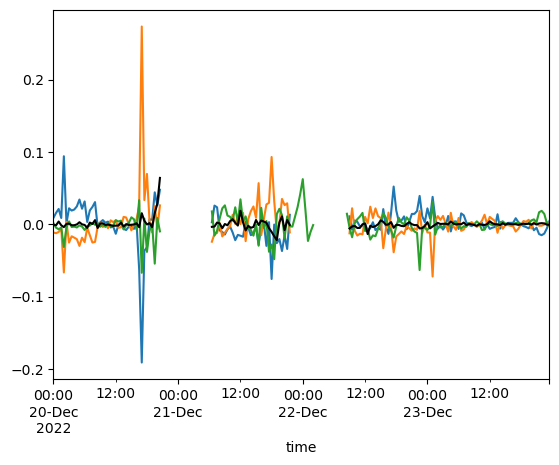

In [146]:
pivot_df['face1_projected_flux'].loc['20221220':'20221223'].plot()
pivot_df['face2_projected_flux'].loc['20221220':'20221223'].plot()
pivot_df['face3_projected_flux'].loc['20221220':'20221223'].plot()
pivot_df['sum_face_projected_flux'].loc['20221220':'20221223'].plot(color='black')

<Axes: xlabel='time'>

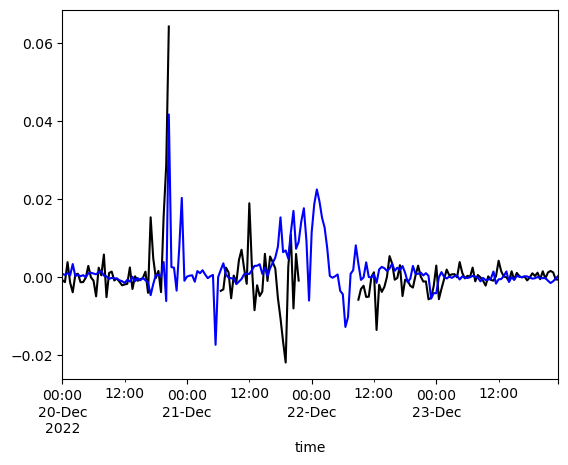

In [147]:
pivot_df['sum_face_projected_flux'].loc['20221220':'20221223'].plot(color='black')
pivot_df['vertical_divergence'].loc['20221220':'20221223'].plot(color='blue')


<Axes: xlabel='time'>

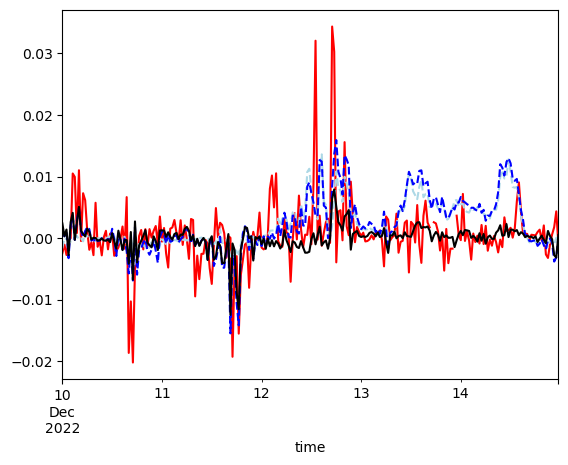

In [197]:
pivot_df['sum_face_projected_flux'].loc['20221210':'20221214'].plot(color='red')
average_upward_3m_flux.loc['20221210':'20221214'].plot(color='lightblue', linestyle='--')
average_upward_10m_flux.loc['20221210':'20221214'].plot(color='blue', linestyle='--')
pivot_df['vertical_divergence'].loc['20221210':'20221214'].plot(color='black')

<Axes: xlabel='time'>

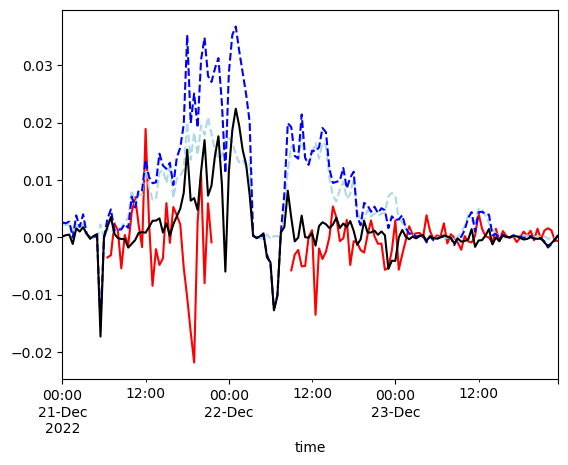

In [196]:
pivot_df['sum_face_projected_flux'].loc['20221221':'20221223'].plot(color='red')
average_upward_3m_flux.loc['20221221':'20221223'].plot(color='lightblue', linestyle='--')
average_upward_10m_flux.loc['20221221':'20221223'].plot(color='blue', linestyle='--')
pivot_df['vertical_divergence'].loc['20221221':'20221223'].plot(color='black')

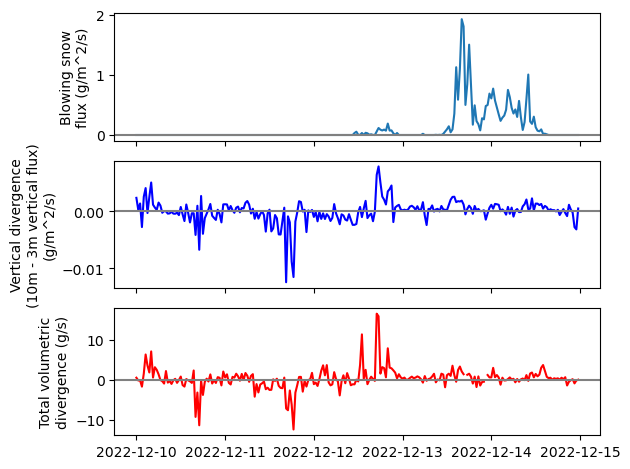

In [189]:
fig, axes = plt.subplots(3,1, sharex=True)
axes[0].plot(
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc['20221210':'20221214'].index,
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc['20221210':'20221214'].value
)
axes[1].plot(
    pivot_df['vertical_divergence'].loc['20221210':'20221214'].index,
    pivot_df['vertical_divergence'].loc['20221210':'20221214'],
    color='blue'
)
axes[2].plot(
    pivot_df['total_divergence'].loc['20221210':'20221214'].index,
    pivot_df['total_divergence'].loc['20221210':'20221214'],
    color='red'
)
axes[0].axhline(0, color='grey')
axes[1].axhline(0, color='grey')
axes[2].axhline(0, color='grey')
axes[0].set_ylabel("Blowing snow\nflux (g/m^2/s)")
axes[1].set_ylabel("Vertical divergence\n(10m - 3m vertical flux)\n(g/m^2/s)")
axes[2].set_ylabel("Total volumetric\ndivergence (g/s)")
plt.tight_layout()

In [202]:
pivot_df[pivot_df.index.isin(bs_times)]['total_divergence'].mean(), pivot_df[pivot_df.index.isin(nobs_times)]['total_divergence'].mean(), pivot_df['total_divergence'].mean()

(0.4548645104732446, -0.160184958767765, -0.017845773822237548)

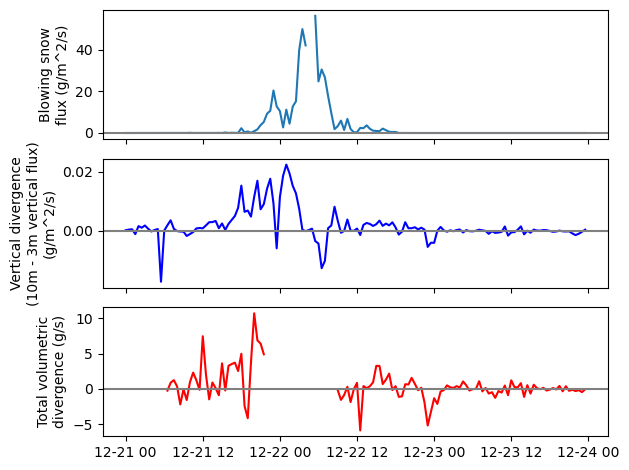

In [190]:
fig, axes = plt.subplots(3,1, sharex=True)
axes[0].plot(
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc['20221221':'20221223'].index,
    tidy_df.query("variable == 'SF_avg_ue'").set_index('time').sort_index().loc['20221221':'20221223'].value
)
axes[1].plot(
    pivot_df['vertical_divergence'].loc['20221221':'20221223'].index,
    pivot_df['vertical_divergence'].loc['20221221':'20221223'],
    color='blue'
)
axes[2].plot(
    pivot_df['total_divergence'].loc['20221221':'20221223'].index,
    pivot_df['total_divergence'].loc['20221221':'20221223'],
    color='red'
)
axes[0].axhline(0, color='grey')
axes[1].axhline(0, color='grey')
axes[2].axhline(0, color='grey')
axes[0].set_ylabel("Blowing snow\nflux (g/m^2/s)")
axes[1].set_ylabel("Vertical divergence\n(10m - 3m vertical flux)\n(g/m^2/s)")
axes[2].set_ylabel("Total volumetric\ndivergence (g/s)")
plt.tight_layout()

# Open planar fitted data

In [ ]:
planar_fitted_data_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min/")
# planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
planar_fitted_data_df = planar_fitted_data_df.melt(ignore_index=False)

planar_fitted_data_df = planar_fitted_data_df.reset_index()

planar_fitted_data_df['time'] = planar_fitted_data_df['time'] - dt.timedelta(minutes=15)
planar_fitted_data_df = utils.modify_df_timezone(planar_fitted_data_df, pytz.UTC, 'US/Mountain')

planar_fitted_data_df = planar_fitted_data_df[planar_fitted_data_df.time > start_date]
planar_fitted_data_df = planar_fitted_data_df[planar_fitted_data_df.time < end_date]

In [ ]:
fitted_df = planar_fitted_data_df[planar_fitted_data_df.variable.str.endswith('_fit')]
raw_df = planar_fitted_data_df[ ~ planar_fitted_data_df.variable.str.endswith('_fit') ]
len(fitted_df)==len(raw_df), len(fitted_df.columns)==len(raw_df.columns)

In [ ]:
fitted_df['variable'] = fitted_df.variable.apply(lambda str: str.replace('_fit', ''))
fitted_df['height'] = fitted_df.variable.apply(tidy._height_from_variable_name)
fitted_df['measurement'] = fitted_df.variable.apply(tidy._measurement_from_variable_name)
fitted_df['tower'] = fitted_df.variable.apply(tidy._tower_from_variable_name)
fitted_df = fitted_df.drop_duplicates()

raw_df['height'] = raw_df.variable.apply(tidy._height_from_variable_name)
raw_df['measurement'] = raw_df.variable.apply(tidy._measurement_from_variable_name)
raw_df['tower'] = raw_df.variable.apply(tidy._tower_from_variable_name)
raw_df = raw_df.drop_duplicates()

# Identify categories

In [ ]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Separate measurements into categories

In [ ]:
w_h2o__vars = ['w_h2o__1m_ue',
 'w_h2o__2m_ue',
 'w_h2o__2m_d',
 'w_h2o__10m_d',
 'w_h2o__3m_d',
 'w_h2o__10m_uw',
 'w_h2o__3m_uw',
 'w_h2o__10m_ue',
 'w_h2o__3m_ue',
 'w_h2o__15m_c',
 'w_h2o__10m_c',
 'w_h2o__5m_c',
 'w_h2o__3m_c',
 'w_h2o__2m_c',
 'w_h2o__2m_uw',
 'w_h2o__20m_c',
 'w_h2o__2_5m_uw',
 'w_h2o__1m_uw',
 'w_h2o__1m_c',
 'w_h2o__1m_d']

## Use regular data

In [ ]:
tidy_df

from sublimpy import extrautils

In [33]:
tidy_df_streamwise = extrautils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)

In [34]:
w_measurements_df = tidy_df[tidy_df.measurement == 'w']
u_measurements_df = tidy_df[tidy_df.measurement == 'u']
v_measurements_df = tidy_df[tidy_df.measurement == 'v']
q_measurements_df = tidy_df[tidy_df.measurement == 'specific humidity']
tke_measurements_df = tidy_df[tidy_df.measurement  == 'turbulent kinetic energy']
w_w__measurements_df = tidy_df[tidy_df.measurement  == 'w_w_']
w_h2o__measurements_df = tidy_df[tidy_df.variable.isin(w_h2o__vars)]
u_h2o__measurements_df = tidy_df[tidy_df.measurement == 'u_h2o_']
v_h2o__measurements_df = tidy_df[tidy_df.measurement == 'v_h2o_']

## Use raw data

In [35]:
w_measurements_df = raw_df[raw_df.measurement == 'w']
u_measurements_df = raw_df[raw_df.measurement == 'u']
v_measurements_df = raw_df[raw_df.measurement == 'v']
q_measurements_df = raw_df[raw_df.measurement == 'specific humidity']
tke_measurements_df = raw_df[raw_df.measurement  == 'turbulent kinetic energy']
w_w__measurements_df = raw_df[raw_df.measurement  == 'w_w_']
w_h2o__measurements_df = raw_df[raw_df.variable.isin(w_h2o__vars)]
u_h2o__measurements_df = raw_df[raw_df.measurement == 'u_h2o_']
v_h2o__measurements_df = raw_df[raw_df.measurement == 'v_h2o_']

## Use planar-fitted data

In [36]:
w_measurements_df = fitted_df[fitted_df.measurement == 'w']
u_measurements_df = fitted_df[fitted_df.measurement == 'u']
v_measurements_df = fitted_df[fitted_df.measurement == 'v']
q_measurements_df = fitted_df[fitted_df.measurement == 'specific humidity']
tke_measurements_df = fitted_df[fitted_df.measurement  == 'turbulent kinetic energy']
w_w__measurements_df = fitted_df[fitted_df.measurement  == 'w_w_']
w_h2o__measurements_df = fitted_df[fitted_df.variable.isin(w_h2o__vars)]
u_h2o__measurements_df = fitted_df[fitted_df.measurement == 'u_h2o_']
v_h2o__measurements_df = fitted_df[fitted_df.measurement == 'v_h2o_']

# Create sub groups of the separate measurements

In [37]:
def filt_times(df, times):
    return df[df.time.isin(times)]

def get_groups(df):
    return (
        filt_times(df, bs_times),
        filt_times(df, nobs_times),
        filt_times(df, decoupled_times),
        filt_times(df, weaklycoupled_times),
        filt_times(df, coupled_times),
        filt_times(df, ri_stable_times),
        filt_times(df, ri_unstable_times),
        filt_times(df, ri_neutral_times),
        filt_times(df, tgrad_stable_times),
        filt_times(df, tgrad_unstable_times),
        filt_times(df, tgrad_neutral_times)
    )

# <w> measurements - divide into groups
(bs_w_df, nobs_w_df, decoupled_w_df, weaklycoupled_w_df, coupled_w_df, 
ri_stable_w_df, ri_unstable_w_df, ri_neutral_w_df, 
tgrad_stable_w_df, tgrad_unstable_w_df, tgrad_neutral_w_df ) = get_groups(w_measurements_df)

# <u> measurements - divide into groups
(bs_u_df, nobs_u_df, decoupled_u_df, weaklycoupled_u_df, coupled_u_df, 
ri_stable_u_df, ri_unstable_u_df, ri_neutral_u_df, 
tgrad_stable_u_df, tgrad_unstable_u_df, tgrad_neutral_u_df ) = get_groups(u_measurements_df)

# <v> measurements - divide into groups
(bs_v_df, nobs_v_df, decoupled_v_df, weaklycoupled_v_df, coupled_v_df, 
ri_stable_v_df, ri_unstable_v_df, ri_neutral_v_df, 
tgrad_stable_v_df, tgrad_unstable_v_df, tgrad_neutral_v_df ) = get_groups(v_measurements_df)

# <q> measurements - divide into groups
(bs_q_df, nobs_q_df, decoupled_q_df, weaklycoupled_q_df, coupled_q_df, 
ri_stable_q_df, ri_unstable_q_df, ri_neutral_q_df, 
tgrad_stable_q_df, tgrad_unstable_q_df, tgrad_neutral_q_df ) = get_groups(q_measurements_df)

# tke measurements - divide into groups
(bs_tke_df, nobs_tke_df, decoupled_tke_df, weaklycoupled_tke_df, coupled_tke_df, 
ri_stable_tke_df, ri_unstable_tke_df, ri_neutral_tke_df, 
tgrad_stable_tke_df, tgrad_unstable_tke_df, tgrad_neutral_tke_df ) = get_groups(tke_measurements_df)

# <w'w'> measurements - divide into groups
(bs_w_w__df, nobs_w_w__df, decoupled_w_w__df, weaklycoupled_w_w__df, coupled_w_w__df, 
ri_stable_w_w__df, ri_unstable_w_w__df, ri_neutral_w_w__df, 
tgrad_stable_w_w__df, tgrad_unstable_w_w__df, tgrad_neutral_w_w__df ) = get_groups(w_w__measurements_df)

# <w'q'> measurements - divide into groups
(bs_w_h2o_df, nobs_w_h2o_df, decoupled_w_h2o_df, weaklycoupled_w_h2o_df, coupled_w_h2o_df, 
ri_stable_w_h2o_df, ri_unstable_w_h2o_df, ri_neutral_w_h2o_df, 
tgrad_stable_w_h2o_df, tgrad_unstable_w_h2o_df, tgrad_neutral_w_h2o_df ) = get_groups(w_h2o__measurements_df)

# create dfs that have bs/no-bs labels
w_h2o__df_with_bs_indicator = pd.concat([
    filt_times(w_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(w_h2o__measurements_df, bs_times).assign(conditions='BS')
])
w_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
w_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
w_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( w_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( w_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])


# <u'q'> measurements - divide into groups
(bs_u_h2o_df, nobs_u_h2o_df, decoupled_u_h2o_df, weaklycoupled_u_h2o_df, coupled_u_h2o_df, 
ri_stable_u_h2o_df, ri_unstable_u_h2o_df, ri_neutral_u_h2o_df, 
tgrad_stable_u_h2o_df, tgrad_unstable_u_h2o_df, tgrad_neutral_u_h2o_df ) = get_groups(u_h2o__measurements_df)

u_h2o__df_with_bs_indicator = pd.concat([
    filt_times(u_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(u_h2o__measurements_df, bs_times).assign(conditions='BS')
])
u_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
u_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
u_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( u_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( u_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])

# <v'q'> measurements - divide into groups
(bs_v_h2o_df, nobs_v_h2o_df, decoupled_v_h2o_df, weaklycoupled_v_h2o_df, coupled_v_h2o_df, 
ri_stable_v_h2o_df, ri_unstable_v_h2o_df, ri_neutral_v_h2o_df, 
tgrad_stable_v_h2o_df, tgrad_unstable_v_h2o_df, tgrad_neutral_v_h2o_df ) = get_groups(v_h2o__measurements_df)

v_h2o__df_with_bs_indicator = pd.concat([
    filt_times(v_h2o__measurements_df, nobs_times).assign(conditions='No BS'),
    filt_times(v_h2o__measurements_df, bs_times).assign(conditions='BS')
])
v_h2o__tgrad_stable_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_stable_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_stable_times))).assign(conditions='BS')
])
v_h2o__tgrad_neutral_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_neutral_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_neutral_times))).assign(conditions='BS')
])
v_h2o__tgrad_unstable_df_with_bs_indicator = pd.concat([
    filt_times( v_h2o__measurements_df, set(nobs_times).intersection(set(tgrad_unstable_times))).assign(conditions='No BS'),
    filt_times( v_h2o__measurements_df, set(bs_times).intersection(set(tgrad_unstable_times))).assign(conditions='BS')
])


# Calculate frequency of lh flux divergence 

Use two different thresholds, 10% and 30%

We compare measurements at 2 measurement heights at a time (2 and 3, and 3 and 5). This is not comprehensive.

In [38]:
src = w_h2o__measurements_df.pivot(index='time', columns='variable', values='value')
src_w = w_measurements_df.pivot(index='time', columns='variable', values='value')

ValueError: Index contains duplicate entries, cannot reshape

## Using 2 and 3 meter measurements and 3 and 5 meter measurements

In [ ]:
src['percent diff 2 3'] = (src['w_h2o__3m_c'] - src['w_h2o__2m_c']) / src[['w_h2o__3m_c', 'w_h2o__2m_c']].mean(axis=1)
src['percent diff 3 5'] = (src['w_h2o__5m_c'] - src['w_h2o__3m_c']) / src[['w_h2o__5m_c', 'w_h2o__3m_c']].mean(axis=1)

percent_gt_10_2_3 = len(src[src["percent diff 2 3"] > 0.1])/len(src)
percent_gt_10_3_5 = len(src[src["percent diff 3 5"] > 0.1])/len(src)
percent_gt_30_2_3 = len(src[src["percent diff 2 3"] > 0.3])/len(src)
percent_gt_30_3_5 = len(src[src["percent diff 3 5"] > 0.3])/len(src)

print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")

In [ ]:
for name, times in [
    ("bs_times", bs_times,),
    ("nobs_times", nobs_times,),
    ("decoupled_times", decoupled_times,),
    ("weaklycoupled_times", weaklycoupled_times,),
    ("coupled_times", coupled_times,),
    ("ri_stable_times", ri_stable_times,),
    ("ri_unstable_times", ri_unstable_times,),
    ("ri_neutral_times", ri_neutral_times,),
    ("tgrad_stable_times", tgrad_stable_times,),
    ("tgrad_unstable_times", tgrad_unstable_times,),
    ("tgrad_neutral_times", tgrad_neutral_times),
]:
    local_src = src.reset_index()
    local_src = local_src[local_src.time.isin(times)]
    percent_gt_10_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.1])/len(local_src)
    percent_gt_10_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.1])/len(local_src)
    percent_gt_30_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.3])/len(local_src)
    percent_gt_30_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.3])/len(local_src)
    print(name)
    print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
    print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")
    print()

# Define functions for plotting profiles

In [39]:
def profile_chart(df, title, x_title):
    return (
        alt.Chart(df).mark_line().encode(
            alt.X("mean(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=100, height=100)
    )

def lhflux_profile_chart(df, title):
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("mean(value):Q").sort('-y').title("<w'q'> (g/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def lhflux_profile_chart_split_conditions(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height', 'tower', 'conditions']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("mean(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(title=[title, f"(n = {n_bs} BS, {n_nobs} No BS)"], width=150, height=150)
    )

def lhflux_profile_chart_split_conditions_noerror(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return alt.Chart(df).mark_line(point=True).encode(
            alt.X("mean(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(title=[title, f"(n = {n_bs} BS, {n_nobs} No BS)"], width=150, height=150)

def lhflux_profile_chart_notower(df, title, x_title="<w'q'> (g/m^2/s)"):
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.2, color='black').encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True),
        )
        +
        alt.Chart(df).mark_line(point=alt.OverlayMarkDef(color='black'), color='black').encode(
            alt.X("mean(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def lhflux_profile_chart_mg(df, title):
    df.value = df.value*1000
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("mean(value):Q").sort('-y').title("<w'q'> (mg/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def profile_chart(df, title, x_title, color="tower:N"):
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("mean(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("height (m)"),
            alt.Color(color)
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

# Plot vertical profiles using the basic categories (stability and BS)

In [40]:
combo_mean_w_profile_chart = (
        profile_chart(w_measurements_df.query("height > 1"), "All data", '<w> (m/s)') | 
        profile_chart(bs_w_df.query("height > 1"), "BS", '<w> (m/s)') | 
        profile_chart(nobs_w_df.query("height > 1"), "No BS", '<w> (m/s)') |         
        profile_chart(tgrad_stable_w_df.query("height > 1"), "Tgrad stable", '<w> (m/s)') | 
        profile_chart(tgrad_neutral_w_df.query("height > 1"), "Tgrad Neutral", '<w> (m/s)') | 
        profile_chart(tgrad_unstable_w_df.query("height > 1"), "Tgrad Unstable", '<w> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_u_profile_chart = (
        profile_chart(u_measurements_df.query("height > 1"), "All data", '<u> (m/s)') | 
        profile_chart(bs_u_df.query("height > 1"), "BS", '<u> (m/s)') | 
        profile_chart(nobs_u_df.query("height > 1"), "No BS", '<u> (m/s)') |         
        profile_chart(tgrad_stable_u_df.query("height > 1"), "Tgrad stable", '<u> (m/s)') | 
        profile_chart(tgrad_neutral_u_df.query("height > 1"), "Tgrad Neutral", '<u> (m/s)') | 
        profile_chart(tgrad_unstable_u_df.query("height > 1"), "Tgrad Unstable", '<u> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_v_profile_chart = ( 
        profile_chart(v_measurements_df.query("height > 1"), "All data", '<v> (m/s)') | 
        profile_chart(bs_v_df.query("height > 1"), "BS", '<v> (m/s)') | 
        profile_chart(nobs_v_df.query("height > 1"), "No BS", '<v> (m/s)') |         
        profile_chart(tgrad_stable_v_df.query("height > 1"), "Tgrad stable", '<v> (m/s)') | 
        profile_chart(tgrad_neutral_v_df.query("height > 1"), "Tgrad Neutral", '<v> (m/s)') | 
        profile_chart(tgrad_unstable_v_df.query("height > 1"), "Tgrad Unstable", '<v> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_tke_profile_chart = (
        profile_chart(tke_measurements_df.query("height > 1"), "All data", 'tke (m^2/s^2)') | 
        profile_chart(bs_tke_df.query("height > 1"), "BS", 'tke (m^2/s^2)') | 
        profile_chart(nobs_tke_df.query("height > 1"), "No BS", 'tke (m^2/s^2)') |         
        profile_chart(tgrad_stable_tke_df.query("height > 1"), "Tgrad stable", 'tke (m^2/s^2)') | 
        profile_chart(tgrad_neutral_tke_df.query("height > 1"), "Tgrad Neutral", 'tke (m^2/s^2)') | 
        profile_chart(tgrad_unstable_tke_df.query("height > 1"), "Tgrad Unstable", 'tke (m^2/s^2)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_w_w__profile_chart = (
        profile_chart(w_w__measurements_df.query("height > 1"), "All data", "<w'w'> (m^2/s^2)") | 
        profile_chart(bs_w_w__df.query("height > 1"), "BS", "<w'w'> (m^2/s^2)") | 
        profile_chart(nobs_w_w__df.query("height > 1"), "No BS", "<w'w'> (m^2/s^2)") |
        profile_chart(tgrad_stable_w_w__df.query("height > 1"), "Tgrad stable", "<w'w'> (m^2/s^2)") | 
        profile_chart(tgrad_neutral_w_w__df.query("height > 1"), "Tgrad Neutral", "<w'w'> (m^2/s^2)") | 
        profile_chart(tgrad_unstable_w_w__df.query("height > 1"), "Tgrad Unstable", "<w'w'> (m^2/s^2)") #| 
).resolve_scale(x='shared', y='shared')

combo_mean_q_profile_chart = (
        profile_chart(q_measurements_df.query("height > 1"), "All data", '<q> (m/s)') | 
        profile_chart(bs_q_df.query("height > 1"), "BS", '<q> (m/s)') | 
        profile_chart(nobs_q_df.query("height > 1"), "No BS", '<q> (m/s)') |         
        profile_chart(tgrad_stable_q_df.query("height > 1"), "Tgrad stable", '<q> (m/s)') | 
        profile_chart(tgrad_neutral_q_df.query("height > 1"), "Tgrad Neutral", '<q> (m/s)') | 
        profile_chart(tgrad_unstable_q_df.query("height > 1"), "Tgrad Unstable", '<q> (m/s)') #| 
).resolve_scale(x='shared', y='shared')

combo_mean_w_q__profile_chart = (
    lhflux_profile_chart(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") | 
    lhflux_profile_chart(bs_w_h2o_df.query("tower == 'c'").query("height > 1"), "BS") | 
    lhflux_profile_chart(nobs_w_h2o_df.query("tower == 'c'").query("height > 1"), "No BS") | 
    lhflux_profile_chart(tgrad_stable_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad stable") | 
    lhflux_profile_chart(tgrad_neutral_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad Neutral") | 
    lhflux_profile_chart(tgrad_unstable_w_h2o_df.query("tower == 'c'").query("height > 1"), "Tgrad Unstable") #
).resolve_scale(x='shared', y='shared')

combo_mean_u_q__profile_chart = (
    profile_chart(u_h2o__measurements_df.query("height > 1"),  "All data",         "<u'q'> (g/m^2/s)") | 
    profile_chart(bs_u_h2o_df.query("height > 1"),               "BS",               "<u'q'> (g/m^2/s)") | 
    profile_chart(nobs_u_h2o_df.query("height > 1"),             "No BS",            "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_stable_u_h2o_df.query("height > 1"),     "Tgrad stable",     "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_neutral_u_h2o_df.query("height > 1"),    "Tgrad Neutral",    "<u'q'> (g/m^2/s)") | 
    profile_chart(tgrad_unstable_u_h2o_df.query("height > 1"),   "Tgrad Unstable",   "<u'q'> (g/m^2/s)") #
).resolve_scale(x='shared', y='shared')

combo_mean_v_q__profile_chart = (
    profile_chart(v_h2o__measurements_df.query("height > 1"),  "All data",         "<v'q'> (g/m^2/s)") | 
    profile_chart(bs_v_h2o_df.query("height > 1"),               "BS",               "<v'q'> (g/m^2/s)") | 
    profile_chart(nobs_v_h2o_df.query("height > 1"),             "No BS",            "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_stable_v_h2o_df.query("height > 1"),     "Tgrad stable",     "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_neutral_v_h2o_df.query("height > 1"),    "Tgrad Neutral",    "<v'q'> (g/m^2/s)") | 
    profile_chart(tgrad_unstable_v_h2o_df.query("height > 1"),   "Tgrad Unstable",   "<v'q'> (g/m^2/s)") #
).resolve_scale(x='shared', y='shared')

In [41]:
(
    e & 
    combo_mean_u_q__profile_chart & 
    combo_mean_v_q__profile_chart &
    combo_mean_w_profile_chart & 
    combo_mean_u_profile_chart &
    combo_mean_v_profile_chart &
    combo_mean_q_profile_chart & 
    combo_mean_tke_profile_chart &
    combo_mean_w_w__profile_chart
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-21 1800")
        &
        (df.time < "2022-12-22 0600")
    ]


lhflux_profile_chart(filter_to_case_study(lhflux_measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(lateral_lhflux_measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-12 1800")
        &
        (df.time < "2022-12-13 0600")
    ]


lhflux_profile_chart(filter_to_case_study(lhflux_measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(lateral_lhflux_measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-03-28 0900")
        &
        (df.time < "2023-03-28 1700")
    ]


lhflux_profile_chart(filter_to_case_study(lhflux_measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(lateral_lhflux_measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-05-05 0900")
        &
        (df.time < "2023-05-05 1700")
    ]


lhflux_profile_chart(filter_to_case_study(lhflux_measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(lateral_lhflux_measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

# Plot vertical fluxes many different ways

In [ ]:
rule = alt.Chart().transform_calculate(rule='0').mark_rule().encode(x='rule:Q')

In [ ]:
tgrad_unstable_df_during_bs = tgrad_unstable_df[tgrad_unstable_df.time.isin(bs_times)]
tgrad_unstable_df_during_nobs = tgrad_unstable_df[~tgrad_unstable_df.time.isin(bs_times)]

(
        rule + lhflux_profile_chart(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_bs.query("tower == 'c'").query("height > 1"), "Unstable, BS") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS")
).resolve_scale(x='shared', y='shared')

In [ ]:
tgrad_stable_df_during_nobs = tgrad_stable_df[~tgrad_stable_df.time.isin(bs_times)]
tgrad_unstable_df_during_nobs = tgrad_unstable_df[~tgrad_unstable_df.time.isin(bs_times)]
tgrad_neutral_df_during_nobs = tgrad_neutral_df[~tgrad_neutral_df.time.isin(bs_times)]

(
    rule + lhflux_profile_chart(lhflux_measurements_df.query("height > 1").query("tower == 'c'"), "All data").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(bs_lhflux_df.query("height > 1").query("tower == 'c'"), "Blowing Snow").properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(nobs_lhflux_df.query("height > 1").query("tower == 'c'"), "No blowing snow").properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(tgrad_stable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Stable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_neutral_df_during_nobs.query("tower == 'c'").query("height > 1"), "Neutral, no BS").properties(width=100, height = 100)
).resolve_scale(x='shared', y='shared')

In [ ]:
(
    (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, daytime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared') & (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, nighttime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, nighttime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared').properties(
    title='Mean water vapor flux profiles across snow-on season'
)

In [ ]:
vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(lhflux_measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

HELLO YOU ARE WORKING HERE

In [ ]:
src_neutral = tgrad_neutral_df_with_bs_indicator.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_neutral.conditions = src_neutral.time.dt.hour
src_neutral['conditions group'] = pd.cut(src_neutral.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_neutral['conditions'] = src_neutral['conditions group'].apply(lambda interval: int(interval.left))

src_unstable = tgrad_unstable_df_with_bs_indicator.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_unstable.conditions = src_unstable.time.dt.hour
src_unstable['conditions group'] = pd.cut(src_unstable.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_unstable['conditions'] = src_unstable['conditions group'].apply(lambda interval: int(interval.left))

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow'))
)

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Facet(f"conditions:O"))
)

In [ ]:
lateral_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(lateral_lhflux_measurements_df.query("tower == 'c'").query("height > 1"), "All data", x_title="<u'q'> (g/m^2/s)") |
    lhflux_profile_chart_split_conditions(lateralflux_tgrad_stable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Stable", x_title="<u'q'> (g/m^2/s)") |
    lhflux_profile_chart_split_conditions(lateralflux_tgrad_neutral_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Neutral", x_title="<u'q'> (g/m^2/s)") |
    lhflux_profile_chart_split_conditions(lateralflux_tgrad_unstable_df_with_bs_indicator.query("tower == 'c'").query("height > 1"), "Unstable", x_title="<u'q'> (g/m^2/s)")
).resolve_scale(x='shared', y='shared') 

In [ ]:
vertical_and_lateral_flux_profiles = (
    vertical_flux_profiles_4_plots & lateral_flux_profiles_4_plots
)
vertical_and_lateral_flux_profiles.save("../../figures/lhflux_profiles_vertical_and_lateral_mean.png", ppi=200)
vertical_and_lateral_flux_profiles

In [ ]:
src_all_data_bs = lateralflux_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_stable_bs = lateralflux_tgrad_stable_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_neutral_bs = lateralflux_tgrad_neutral_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")
src_unstable_bs = lateralflux_tgrad_unstable_df_with_bs_indicator.query("conditions == 'BS'").query("height > 1")

src_all_data_nobs = lateralflux_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_stable_nobs = lateralflux_tgrad_stable_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_neutral_nobs = lateralflux_tgrad_neutral_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")
src_unstable_nobs = lateralflux_tgrad_unstable_df_with_bs_indicator.query("conditions == 'No BS'").query("height > 1")



(
    (
        profile_chart(src_all_data_bs,    "All data, BS",   "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_stable_bs,      "Stable, BS",     "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_neutral_bs,     "Neutral, BS",    "<u'q'> (g/m^2/s)",     'tower:N') |
        profile_chart(src_unstable_bs,    "Unstable, BS",   "<u'q'> (g/m^2/s)",     'tower:N')
    ).resolve_scale(x='shared', y='shared') & (
        profile_chart(src_all_data_nobs,    "All data, No BS",  "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_stable_nobs,      "Stable, No BS",    "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_neutral_nobs,     "Neutral, No BS",   "<u'q'> (g/m^2/s)", 'tower:N') |
        profile_chart(src_unstable_nobs,    "Unstable, No BS",  "<u'q'> (g/m^2/s)", 'tower:N')
    ).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared')

In [ ]:
daytime_df = lhflux_measurements_df[lhflux_measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])]
daytime_df['date'] = daytime_df.time.dt.strftime('%Y%m%d')
daytime_df['month'] = daytime_df.time.dt.month
daytime_daily_mean_profiles_df = daytime_df.groupby(['date', 'month', 'variable', 'height', 'tower'])[['value']].mean().reset_index()

In [ ]:
alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 12").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 1").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 2").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 3").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 4").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 5").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80)

# Examine how divergence varies with instrument distance from snow surface

In [ ]:
div_variation = tidy_df[tidy_df.variable.isin([
    # 'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'SnowDepth_c',
])].pivot(index='time', columns='variable', values='value').reset_index()
div_variation['height_adj'] = 2 - div_variation['SnowDepth_c']

div_variation['lhflux_div_2_3'] = (div_variation['w_h2o__3m_c'] - div_variation['w_h2o__2m_c']) / 1
div_variation['lhflux_div_3_5'] = (div_variation['w_h2o__5m_c'] - div_variation['w_h2o__3m_c']) / 2
div_variation['lhflux_div_5_10'] = (div_variation['w_h2o__10m_c'] - div_variation['w_h2o__5m_c']) / 5

In [ ]:
chart_2_3 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_2_3 <= 1
).transform_filter(
    alt.datum.lhflux_div_2_3 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_2_3:Q").title("d(w'q')/dz, 2-3m")
) + alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_3_5 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_3_5 <= 1
).transform_filter(
    alt.datum.lhflux_div_3_5 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_3_5:Q").title("d(w'q')/dz, 3-5m")
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_5_10 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_5_10 <= 1
).transform_filter(
    alt.datum.lhflux_div_5_10 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_5_10:Q").title(("d(w'q')/dz, 5-10m"))
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

(chart_2_3 & chart_3_5 & chart_5_10).display(renderer='svg')

In [ ]:
import scipy.stats
scipy.stats.ks_2samp

In [ ]:
snow_is_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

In [ ]:
snow_is_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

# December wind event case study

## Plot Vertical Profiles

Sensible heat

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_tc__1m_c', 'w_tc__2m_c', 'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c',
    'w_tc__1m_ue',  'w_tc__1m_uw',  'w_tc__1m_d',
    'w_tc__3m_ue',  'w_tc__3m_uw',  'w_tc__3m_d',
    'w_tc__10m_ue', 'w_tc__10m_uw', 'w_tc__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_tc_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("w'tc'"), #.scale(domain=[-0.25,0], clamp=True),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
    ).properties(width=75,height=75)

Potential temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface potential temperature',
    'potential temperature'
])].query("tower == 'c'")
theta_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

Temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface temperature',
    'temperature'
])].query("tower == 'c'")
T_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)
T_prof_timeseries_chart

lh flux 

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c', 'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__1m_ue',  'w_h2o__1m_uw',  'w_h2o__1m_d',
    'w_h2o__3m_ue',  'w_h2o__3m_uw',  'w_h2o__3m_d',
    'w_h2o__10m_ue', 'w_h2o__10m_uw', 'w_h2o__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_q_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("w'q'"),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=75,height=75)

In [ ]:
alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 1955": "2022-12-21 2005"
    ].reset_index().query("tower == 'c'").query("height <= 10")
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("<w'q'> (g/m^2/s)"),
        alt.Y("height:Q").scale(domain=[0,20]).title("height (m)"),
        # alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=100,height=100)

RH

In [ ]:
src = tidy_df[tidy_df.measurement=='RH'].query("height != 6").query("height != 12")
rh_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_circle().encode(
        alt.X("mean(value):Q").sort('-y').title("RH (%)").scale(domain=[55,75]),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

blowing snow time series

In [ ]:
# src = tidy_df[tidy_df.variable == 'SF_avg_ue']
src = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])]
# src = src[src.time.isin(bs_times)]
bs_flux_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_circle(point=True, size=75).encode(
        alt.X("time:T"),
        alt.Y("value:Q").scale(type='log').title("Blowing snow flux (g/m^2/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 

src = tidy_df[tidy_df.variable.isin(['spd_3m_c', 'spd_5m_c', 'spd_20m_c'])]
windspd_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'u*_5m_c', 'u*_20m_c'])]
ufric_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Friction velocity (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


In [ ]:
(
    ufric_timeseries_chart & windspd_timeseries_chart & bs_flux_timeseries_chart & 
    (w_q_prof_timeseries_chart & rh_prof_timeseries_chart & w_tc_prof_timeseries_chart & theta_prof_timeseries_chart)
).resolve_scale(color='independent')

Look at time series of Snow surface temperature, and other related variables, to see what is going on with surface temperatures during the blowing snow event

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "2022-12-21 12": "2022-12-22 23"
].reset_index()
# Create DF with renamed Tsnow variables to clarify that they are air sensors at this time because
# snowdepth during this time period is 30-40cm, so the in-snow T sensors are ~10, 20cm above snow
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_4m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_5m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_6m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_7m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')   

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_0_4m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    "Tsnow_0_4m_d",
    'T_00cm_c'
)

bs_case_study =(alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c'],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20221221": "20221223"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "20230210": "20230212"
].reset_index()
# rename the Tsnow variables so clarify that the snowdepth during this time period is 88cm, 
# so the in-snow T sensors are actually ~10, 20, cm above the snow surface
# When we looked at T sensors at 80cm and 90cm, they were clearly under snow (signal attenuated)
# So we think its a decent estimate that the snow by the instrument is actually ~1m deep
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_1_0m_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    # 'Tsnow_1_4m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_0m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_1m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_2m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_3m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_1_0m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    'Tsnow_1_0m_d',
    'T_00cm_c'
)

clear_case_study = (alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_2m_c', 'T_00cm_c', 'T_10cm_c', 'T_20cm_c','T_30cm_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c','T_30cm_c', 'T_2m_c', ],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
    # alt.StrokeDash("measurement:N"),
    detail='variable'
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    # alt.StrokeDash("measurement:N"),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20230210": "20230212"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q")
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement:N").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
(bs_case_study | clear_case_study)